In [1]:
# Packages

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2023-06-02 19:45:38.387435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Set

You will start by loading the dataset for this task. 
- The `load_data()` function shown below loads the data into variables `X` and `y`


- The data set contains 1000 training examples of handwritten digits $^1$, here limited to zero and one.  

    - Each training example is a 20-pixel x 20-pixel grayscale image of the digit. 
        - Each pixel is represented by a floating-point number indicating the grayscale intensity at that location. 
        - The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. 
        - Each training example becomes a single row in our data matrix `X`. 
        - This gives us a 1000 x 400 matrix `X` where every row is a training example of a handwritten digit image.

$$X = 
\left(\begin{array}{cc} 
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\ 
--- (x^{(m)}) --- 
\end{array}\right)$$ 

- The second part of the training set is a 1000 x 1 dimensional vector `y` that contains labels for the training set
    - `y = 0` if the image is of the digit `0`, `y = 1` if the image is of the digit `1`.

$^1$<sub> This is a subset of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/)</sub>

In [2]:
# Load the Data Set

def load_data():
    X = np.load("X.npy")
    y = np.load("y.npy")
    X = X[0:1000]
    y = y[0:1000]
    return X, y

X, y = load_data()

In [3]:
print(f"Shape of X: {X.shape}")
print(f"The First Element of X is:{X[0]}")
print("\n")
print(f"Shape of Y: {y.shape}")
print(f"The First Element of Y is:{y[0]}")

Shape of X: (1000, 400)
The First Element of X is:[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.0000

#### Visualizing the Data

You will begin by visualizing a subset of the training set. 
- In the cell below, the code randomly selects 64 rows from `X`, maps each row back to a 20 pixel by 20 pixel grayscale image and displays the images together. 
- The label for each image is displayed above the image 

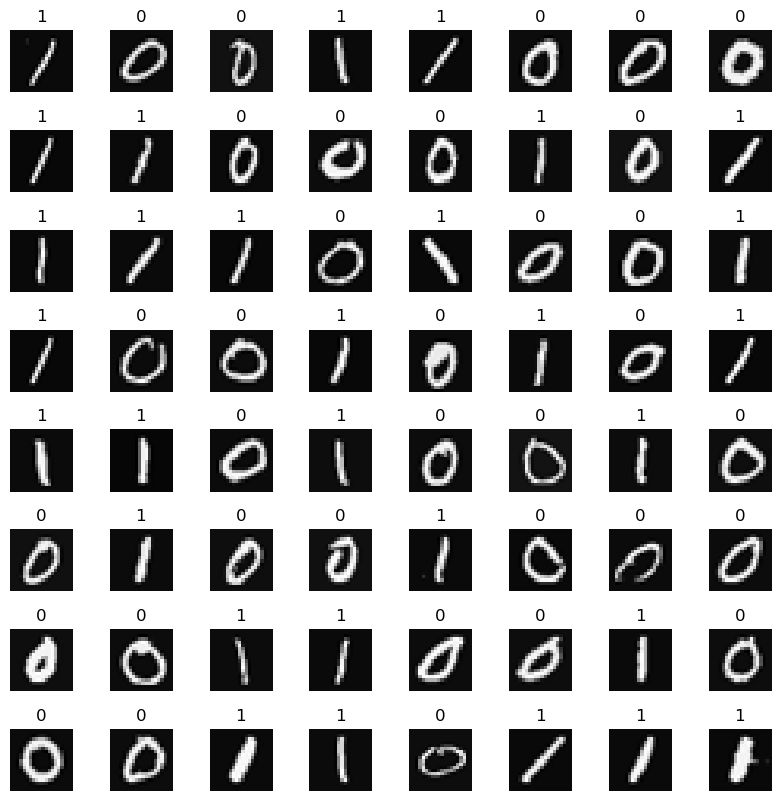

In [4]:
m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1)

for i,ax in enumerate(axes.flat):
    # Select Random Indices
    random_index = np.random.randint(m)
    
    # Select Rows Corresponding to the Random Indices &
    # Reshape the Image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the Image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the Label above the Image
    ax.set_title(y[random_index,0])
    ax.set_axis_off()

## Model Representation

The neural network you will use in this assignment is shown in the figure below. 
- This has three dense layers with sigmoid activations.
    - Recall that our inputs are pixel values of digit images.
    - Since the images are of size $20\times20$, this gives us $400$ inputs  
    
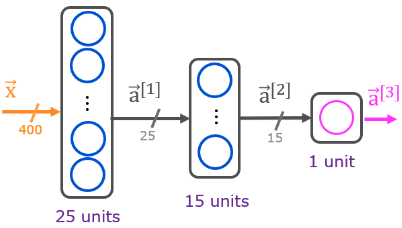

- The parameters have dimensions that are sized for a neural network with $25$ units in layer 1, $15$ units in layer 2 and $1$ output unit in layer 3. 

    - Recall that the dimensions of these parameters are determined as follows:
        - If network has $s_{in}$ units in a layer and $s_{out}$ units in the next layer, then 
            - $W$ will be of dimension $s_{in} \times s_{out}$.
            - $b$ will a vector with $s_{out}$ elements
  
    - Therefore, the shapes of `W`, and `b`,  are 
        - layer1: The shape of `W1` is (400, 25) and the shape of `b1` is (25,)
        - layer2: The shape of `W2` is (25, 15) and the shape of `b2` is: (15,)
        - layer3: The shape of `W3` is (15, 1) and the shape of `b3` is: (1,)
>**Note:** The bias vector `b` could be represented as a 1-D (n,) or 2-D (1,n) array. Tensorflow utilizes a 1-D representation and this lab will maintain that convention. 

## TensorFlow Model Implementation
Tensorflow models are built layer by layer. A layer's input dimensions ($s_{in}$ above) are calculated for you. You specify a layer's *output dimensions* and this determines the next layer's input dimension. The input dimension of the first layer is derived from the size of the input data specified in the `model.fit` statement below. 
>**Note:** It is also possible to add an input layer that specifies the input dimension of the first layer. For example:  
`tf.keras.Input(shape=(400,)),    #specify input shape`  
We will include that here to illuminate some model sizing.

In [5]:
# Model

model = Sequential(
    [
        # Input Size
        tf.keras.Input(shape=(400,)),
        Dense(units=25, activation="sigmoid", name="layer1"),
        Dense(units=15, activation="sigmoid", name="layer2"),
        Dense(units=1 , activation="sigmoid", name="layer3"),
    ], name = "my_model"
)

2023-06-02 19:45:44.223225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 25)                10025     
                                                                 
 layer2 (Dense)              (None, 15)                390       
                                                                 
 layer3 (Dense)              (None, 1)                 16        
                                                                 
Total params: 10,431
Trainable params: 10,431
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Parameter Count

L1_num_params = 400 * 25 + 25  # W1 Parameters  + b1 Parameters
L2_num_params = 25 * 15 + 15   # W2 Parameters  + b2 Parameters
L3_num_params = 15 * 1 + 1     # W3 Parameters  + b3 Parameters

print("L1 params =", L1_num_params, ", L2 params =", L2_num_params, ",  L3 params =", L3_num_params )

L1 params = 10025 , L2 params = 390 ,  L3 params = 16


In [8]:
# Examine the Details

# Extract the Layers
[layer1, layer2, layer3] = model.layers

# Extract the Weights
W1, b1 = layer1.get_weights()
W2, b2 = layer2.get_weights()
W3, b3 = layer3.get_weights()

print(f"W1 Shape = {W1.shape}, b1 Shape = {b1.shape}")
print(f"W2 Shape = {W2.shape}, b2 Shape = {b2.shape}")
print(f"W3 Shape = {W3.shape}, b3 Shape = {b3.shape}")

W1 Shape = (400, 25), b1 Shape = (25,)
W2 Shape = (25, 15), b2 Shape = (15,)
W3 Shape = (15, 1), b3 Shape = (1,)


In [9]:
print(f"W3: {W3}")
print(f"b3: {b3}")

W3: [[ 0.1756047 ]
 [ 0.52946585]
 [-0.5072191 ]
 [ 0.31407964]
 [-0.29523456]
 [-0.35621682]
 [ 0.56830925]
 [ 0.00267929]
 [ 0.05563194]
 [-0.3932802 ]
 [-0.41236633]
 [-0.55086064]
 [-0.2500991 ]
 [ 0.40412253]
 [-0.27364844]]
b3: [0.]


In [10]:
# Shape of the Tensors in the Final Layer

print(model.layers[2].weights)

[<tf.Variable 'layer3/kernel:0' shape=(15, 1) dtype=float32, numpy=
array([[ 0.1756047 ],
       [ 0.52946585],
       [-0.5072191 ],
       [ 0.31407964],
       [-0.29523456],
       [-0.35621682],
       [ 0.56830925],
       [ 0.00267929],
       [ 0.05563194],
       [-0.3932802 ],
       [-0.41236633],
       [-0.55086064],
       [-0.2500991 ],
       [ 0.40412253],
       [-0.27364844]], dtype=float32)>, <tf.Variable 'layer3/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


In [11]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    X,y,
    epochs=20
)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 1s 1ms/step - loss: 0.6489
Epoch 2/20
32/32 [==============================] - 0s 1ms/step - loss: 0.4631
Epoch 3/20
32/32 [==============================] - 0s 2ms/step - loss: 0.3165
Epoch 4/20
32/32 [==============================] - 0s 2ms/step - loss: 0.2154
Epoch 5/20
32/32 [==============================] - 0s 2ms/ste

In [12]:
# Predictions
# The input to predict is an array so the single example is reshaped to be two dimensional.

# a Zero
prediction = model.predict(X[0].reshape(1,400))  
print(f"Predicting a Zero: {prediction}")

# a One
prediction = model.predict(X[500].reshape(1,400))  
print(f"Predicting a One:  {prediction}")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 51ms/step
Predicting a Zero: [[0.0136398]]
1/1 [==============================] - 0s 19ms/step
Predicting a One:  [[0.9815719]]


In [13]:
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print(f"Prediction after a Threshold: {yhat}")

Prediction after a Threshold: 1


1/1 [==============================] - 0s 19ms/step


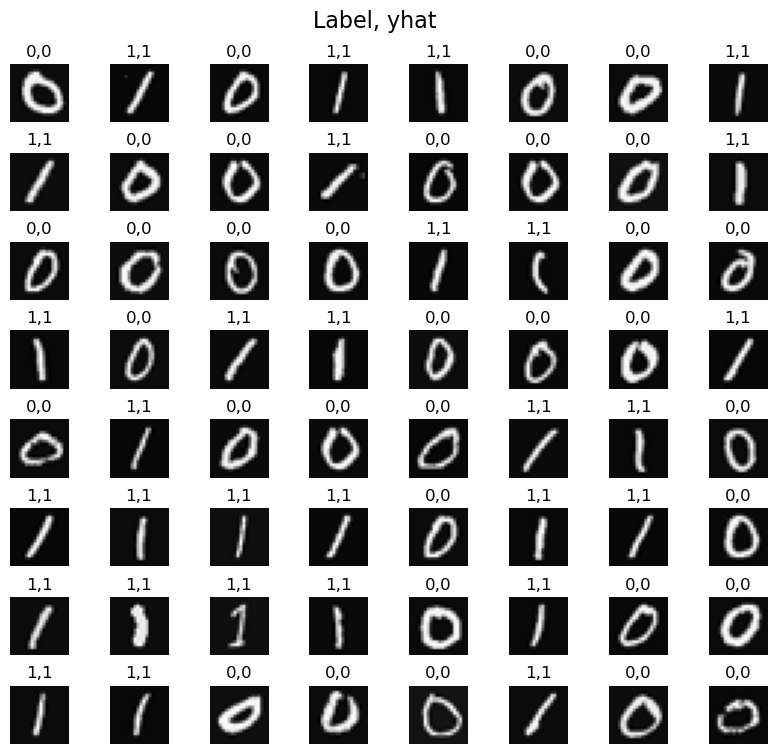

In [14]:
# Compare the Predictions vs the Labels for a Random Sample of 64 Digits

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))

# [Left, Bottom, Right, Top]
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) 

for i,ax in enumerate(axes.flat):
    # Select Random Indices
    random_index = np.random.randint(m)
    
    # Select Rows Corresponding to the Random Indices &
    # Reshape the Image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the Image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Predict Using the Neural Network
    prediction = model.predict(X[random_index].reshape(1,400))
    if prediction >= 0.5:
        yhat = 1
    else:
        yhat = 0
    
    # Display the Label above the Image
    ax.set_title(f"{y[random_index,0]},{yhat}")
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=16)
plt.show()

## NumPy Model Implementation (Forward Propagation)
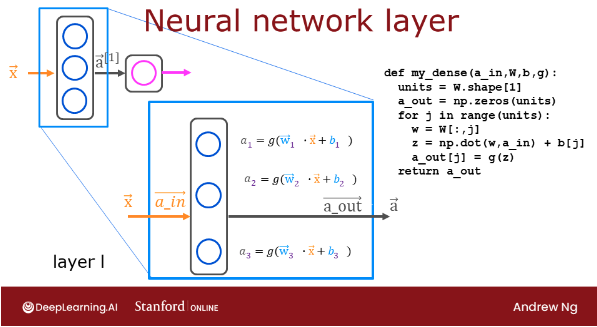

In [15]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))
    

def my_dense(a_in, W, b, g):
    """
    Computes the Dense Layer.
    Args:
      a_in (ndarray (n, )) : Data, 1 example 
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      a_out (ndarray (j,))  : j units
    """ 
    units = W.shape[1]
    a_out = np.zeros(units)
    
    for j in range(units):
        w = W[:,j]
        z = np.dot(w, a_in) + b[j]
        a_out[j] = g(z)
    
    return a_out

In [16]:
# Quick Check

# Expected Output: [0.54735762 0.57932425 0.61063923]
x_tst = 0.1*np.arange(1,3,1).reshape(2,)  # (1 Examples, 2 Features)
W_tst = 0.1*np.arange(1,7,1).reshape(2,3) # (2 Input Features, 3 Output Features)
b_tst = 0.1*np.arange(1,4,1).reshape(3,)  # (3 Features)
A_tst = my_dense(x_tst, W_tst, b_tst, sigmoid)
print(A_tst)

[0.54735762 0.57932425 0.61063923]


In [17]:
# 3 Layer Neural Network

def my_sequential(x, W1, b1, W2, b2, W3, b3):
    a1 = my_dense(x,  W1, b1, sigmoid)
    a2 = my_dense(a1, W2, b2, sigmoid)
    a3 = my_dense(a2, W3, b3, sigmoid)
    return(a3)

In [18]:
# Predictions

# Copy the Trained Weights and Biases from the TensorFlow Model Implementation
W1_tmp,b1_tmp = layer1.get_weights()
W2_tmp,b2_tmp = layer2.get_weights()
W3_tmp,b3_tmp = layer3.get_weights()

prediction = my_sequential(X[0], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print( "yhat = ", yhat, " label= ", y[0,0])

prediction = my_sequential(X[500], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print( "yhat = ", yhat, " label= ", y[500,0])

yhat =  0  label=  0
yhat =  1  label=  1


1/1 [==============================] - 0s 20ms/step


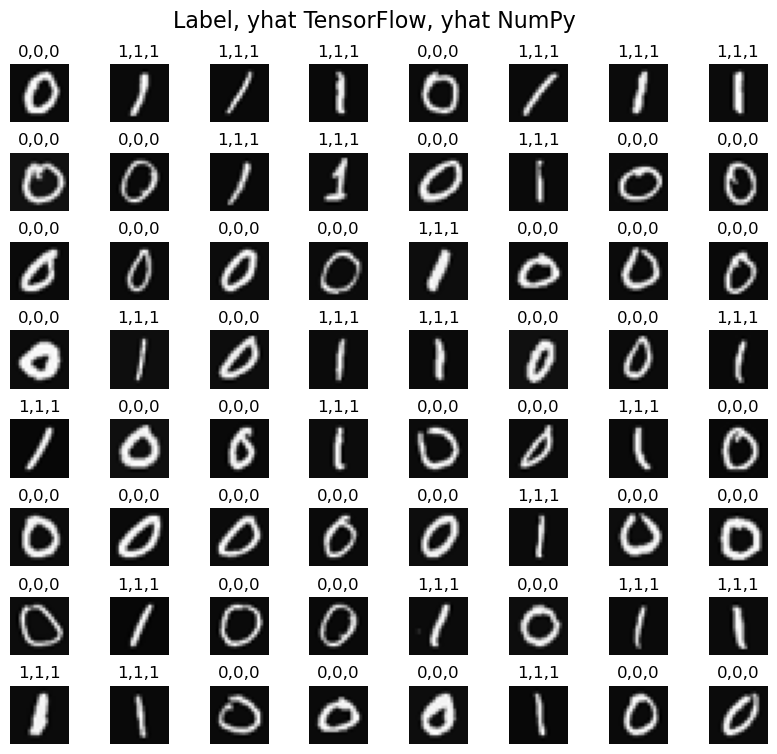

In [19]:
m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))

#[Left, Bottom, Right, Top]
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92])

for i,ax in enumerate(axes.flat):
    # Select Random Indices
    random_index = np.random.randint(m)
    
    # Select Rows Corresponding to the Random Indices &
    # Reshape the Image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the Image
    ax.imshow(X_random_reshaped, cmap='gray')

    # Predict using the Neural Network Implemented in NumPy
    my_prediction = my_sequential(X[random_index], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
    my_yhat = int(my_prediction >= 0.5)

    # Predict using the Neural Network implemented in TensorFlow
    tf_prediction = model.predict(X[random_index].reshape(1,400))
    tf_yhat = int(tf_prediction >= 0.5)
    
    # Display the Label above the Image
    ax.set_title(f"{y[random_index,0]},{tf_yhat},{my_yhat}")
    ax.set_axis_off() 
fig.suptitle("Label, yhat TensorFlow, yhat NumPy", fontsize=16)
plt.show()

## Vectorized NumPy Model Implementation (Forward Propagation)

Below describes a layer operation that computes the output for all units in a layer on a given input example:
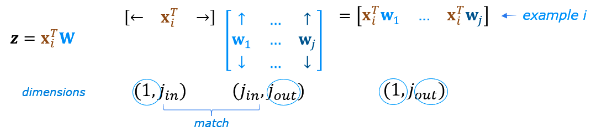
We can demonstrate this using the examples `X` and the `W1`,`b1` parameters above. We use `np.matmul` to perform the matrix multiply. Note, the dimensions of x and W must be compatible as shown in the diagram above.

In [20]:
x = X[0].reshape(-1,1)         # Column Vector (400,1)
z1 = np.matmul(x.T,W1) + b1    # (1,400)(400,25) = (1,25)
a1 = sigmoid(z1)
print(a1.shape)

(1, 25)


You can take this a step further and compute all the units for all examples in one Matrix-Matrix operation.
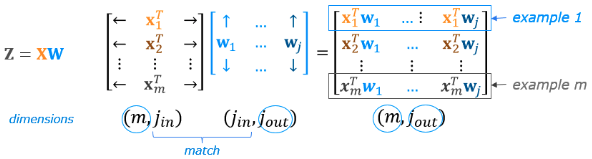
The full operation is $\mathbf{Z}=\mathbf{XW}+\mathbf{b}$. This will utilize NumPy broadcasting to expand $\mathbf{b}$ to $m$ rows. If this is unfamiliar, a short tutorial is provided at the end of the notebook.

In [21]:
def my_dense_v(A_in, W, b, g):
    """
    Computes dense layer
    Args:
      A_in (ndarray (m,n)) : Data, m examples, n features each
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (1,j)) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      A_out (tf.Tensor or ndarray (m,j)) : m examples, j units
    """
    # Note: np.matmul(A_in, W) and np.matmul(W, A_in) is not the same operation!
    A_out = np.matmul(A_in, W) + b
    A_out = g(A_out)
    return A_out

In [22]:
X_tst = 0.1*np.arange(1,9,1).reshape(4,2) # (4 Examples, 2 Features)
W_tst = 0.1*np.arange(1,7,1).reshape(2,3) # (2 Input Features, 3 Output Features)
b_tst = 0.1*np.arange(1,4,1).reshape(1,3) # (1,3 Features)
A_tst = my_dense_v(X_tst, W_tst, b_tst, sigmoid)
print(A_tst)

[[0.54735762 0.57932425 0.61063923]
 [0.57199613 0.61301418 0.65248946]
 [0.5962827  0.64565631 0.6921095 ]
 [0.62010643 0.67699586 0.72908792]]


In [23]:
# 3 Layer Neural Network

def my_sequential_v(X, W1, b1, W2, b2, W3, b3):
    A1 = my_dense_v(X,  W1, b1, sigmoid)
    A2 = my_dense_v(A1, W2, b2, sigmoid)
    A3 = my_dense_v(A2, W3, b3, sigmoid)
    return(A3)

In [24]:
# Predictions (This will make a prediction on all of the examples at once. Note the shape of the output.)

# Copy the Trained Weights and Biases from the TensorFlow Model Implementation
W1_tmp,b1_tmp = layer1.get_weights()
W2_tmp,b2_tmp = layer2.get_weights()
W3_tmp,b3_tmp = layer3.get_weights()

Prediction = my_sequential_v(X, W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
Prediction.shape

(1000, 1)

In [25]:
Yhat = (Prediction >= 0.5).astype(int)
print("Predict a Zero: ",Yhat[0], "Predict a One: ", Yhat[500])

Predict a Zero:  [0] Predict a One:  [1]


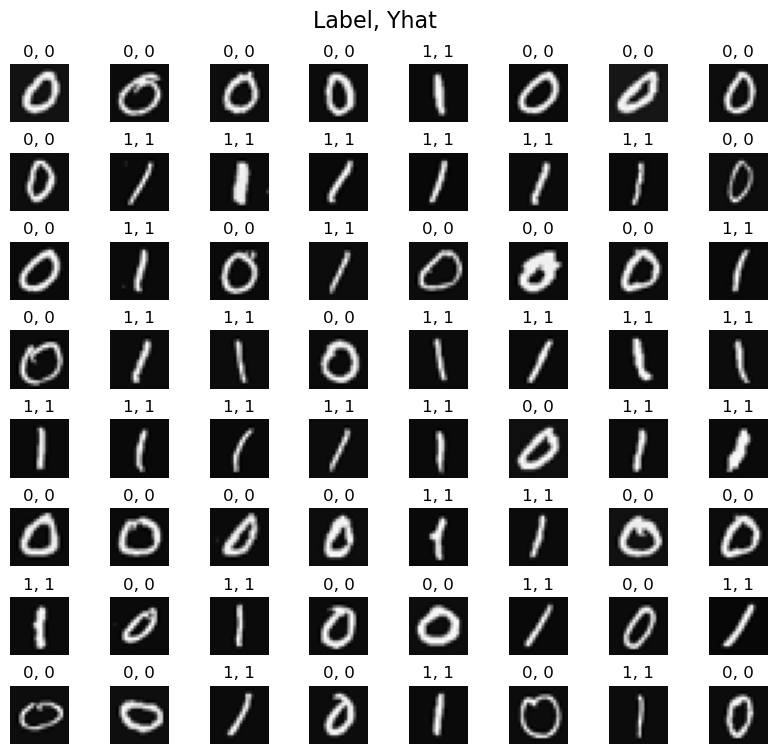

In [26]:
m, n = X.shape

fig, axes = plt.subplots(8, 8, figsize=(8, 8))

#[Left, Bottom, Right, Top]
fig.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.92]) 

for i, ax in enumerate(axes.flat):
    # Select Random Indices
    random_index = np.random.randint(m)
    
    # Select Rows Corresponding to the Random Indices &
    # Reshape the Image
    X_random_reshaped = X[random_index].reshape((20, 20)).T
    
    # Display the Image
    ax.imshow(X_random_reshaped, cmap='gray')
   
    # Display the Label above the Image
    ax.set_title(f"{y[random_index,0]}, {Yhat[random_index, 0]}")
    ax.set_axis_off() 
fig.suptitle("Label, Yhat", fontsize=16)
plt.show()

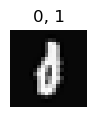

In [27]:
# Misclassified Image

fig = plt.figure(figsize=(1, 1))
errors = np.where(y != Yhat)
random_index = errors[0][0]
X_random_reshaped = X[random_index].reshape((20, 20)).T
plt.imshow(X_random_reshaped, cmap='gray')
plt.title(f"{y[random_index,0]}, {Yhat[random_index, 0]}")
plt.axis('off')
plt.show()

## NumPy Broadcasting

In the last example,  $\mathbf{Z}=\mathbf{XW} + \mathbf{b}$ utilized NumPy broadcasting to expand the vector $\mathbf{b}$. If you are not familiar with NumPy Broadcasting, this short tutorial is provided.

$\mathbf{XW}$  is a matrix-matrix operation with dimensions $(m,j_1)(j_1,j_2)$ which results in a matrix with dimension  $(m,j_2)$. To that, we add a vector $\mathbf{b}$ with dimension $(1,j_2)$.  $\mathbf{b}$ must be expanded to be a $(m,j_2)$ matrix for this element-wise operation to make sense. This expansion is accomplished for you by NumPy broadcasting.

Broadcasting applies to element-wise operations.  
Its basic operation is to 'stretch' a smaller dimension by replicating elements to match a larger dimension.

More [specifically](https://NumPy.org/doc/stable/user/basics.broadcasting.html): 
When operating on two arrays, NumPy compares their shapes element-wise. It starts with the trailing (i.e. rightmost) dimensions and works its way left. Two dimensions are compatible when
- they are equal, or
- one of them is 1   

If these conditions are not met, a ValueError: operands could not be broadcast together exception is thrown, indicating that the arrays have incompatible shapes. The size of the resulting array is the size that is not 1 along each axis of the inputs.

Here are some examples:
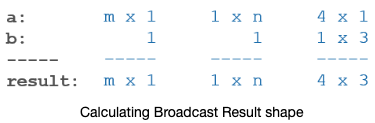

In [28]:
# Example (Note that thiis applies to all element-wise operations.)

a = np.array([1,2,3]).reshape(-1,1)  #(3,1)
b = 5
print(f"(a + b).shape: {(a + b).shape}, \na + b = \n{a + b}")

(a + b).shape: (3, 1), 
a + b = 
[[6]
 [7]
 [8]]


In [29]:
# Example

a = np.array([1,2,3]).reshape(-1,1)  #(3,1)
b = 5
print(f"(a * b).shape: {(a * b).shape}, \na * b = \n{a * b}")

(a * b).shape: (3, 1), 
a * b = 
[[ 5]
 [10]
 [15]]


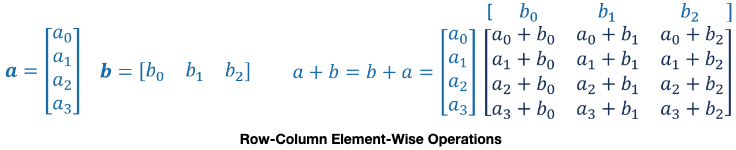

In [30]:
a = np.array([1,2,3,4]).reshape(-1,1) # (4,1)
b = np.array([1,2,3]).reshape(1,-1) # (1,3)
print(f"a:\n {a}")
print(f"b:\n {b}")
print("\n")
print(f"(a + b).shape: {(a + b).shape}, \na + b = \n{a + b}")

a:
 [[1]
 [2]
 [3]
 [4]]
b:
 [[1 2 3]]


(a + b).shape: (4, 3), 
a + b = 
[[2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]]


This is the scenario in the dense layer you built above. Adding a 1-D vector $b$ to a (m,j) matrix.
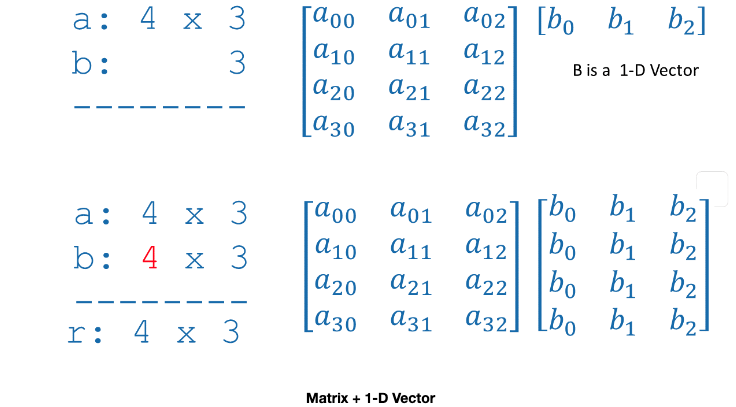